# Calculating the Period-Age Relation for Cepheids

In [3]:
import sys
import numpy as np

from astroquery.simbad import Simbad

from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.timeseries import BoxLeastSquares, LombScargle
from astropy.coordinates import SkyCoord, Angle
from astropy.table import Table, Column
import astropy.units as u

from scipy.ndimage import shift
from scipy.stats import chisquare
from scipy.signal import medfilt, find_peaks
from scipy.odr import Model, RealData, ODR

from photutils import DAOStarFinder, CircularAperture, aperture_photometry
from ccdproc import CCDData, Combiner, subtract_overscan, trim_image
from astroquery.mast import Catalogs
from reproject import reproject_interp

from glob import glob

import matplotlib

%matplotlib inline
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import NullLocator

## Putting all my data together

Using the infor from David and my own calculations.

\* I want to vet my Cepheids based on other datasets, maybe that will get rid of the 51 day one.

In [16]:
pd_age_table = Table(names=["cluster","periods","age","e_age"],
                     data=[["NGC 1818","NGC 1850","NGC 2031","NGC 2136","NGC 2157","NGC 1866"],
                           [[39.999],
                            [18.6639, 8.55965, 7.92288],
                            [2.97151, 3.19436, 3.04226, 3.27879, 3.03111, 2.96081, 2.82426, 2.86926, 2.79717],
                            [4.41422, 9.1301, 4.46552],
                            [7.71987, 5.1472],
                            [2.039, 3.144, 51.519, 2.957, 3.101, 3.037, 3.065, 3.044, 3.291, 3.065, 3.182, 
                             3.058, 3.228, 2.728, 3.452, 0.666, 3.316, 3.525,3.086, 2.944, 0.626]],
                           [30,80,230,125,100,141]*u.Myr,
                           [15,17,30,50,30,20]*u.Myr])

Calculating the mean periods and standard error on the mean do get a single period for each age.

In [17]:
mean_pds = [round(np.mean(x),3) for x in pd_age_table['periods']]

errs = [0]*len(pd_age_table['periods'])
for i,pds in enumerate(pd_age_table['periods']):
    variance = sum([(x - mean_pds[i])**2 for x in pds])/(len(pds))
    errs[i] = round(np.sqrt(variance/len(pds)), 2)

In [18]:
pd_age_table.add_column(Column(name="ave_pd",data=mean_pds*u.day))
pd_age_table.add_column(Column(name="e_ave_pd",data=errs*u.day))

Adding error to the one with a single data point because otherwise it breaks the fitting.

\* Swap out this error with the real uncertaintly when I get the source for that measurement.

\* Note, though that is doesn't really matter, it doesn't affect the output numbers at the level of precision we are sensitive to.

In [49]:
pd_age_table["e_ave_pd"][0] = 0.001

In [50]:
pd_age_table

cluster,periods,age,e_age,ave_pd,e_ave_pd
,,Myr,Myr,d,d
str8,object,float64,float64,float64,float64
NGC 1818,[39.999],30.0,15.0,39.999,0.001
NGC 1850,"[18.6639, 8.55965, 7.92288]",80.0,17.0,11.715,2.84
NGC 2031,"[2.97151, 3.19436, 3.04226, 3.27879, 3.03111, 2.96081, 2.82426, 2.86926, 2.79717]",230.0,30.0,2.997,0.05
NGC 2136,"[4.41422, 9.1301, 4.46552]",125.0,50.0,6.003,1.28
NGC 2157,"[7.71987, 5.1472]",100.0,30.0,6.434,0.91
NGC 1866,"[2.039, 3.144, 51.519, 2.957, 3.101, 3.037, 3.065, 3.044, 3.291, 3.065, 3.182, 3.058, 3.228, 2.728, 3.452, 0.666, 3.316, 3.525, 3.086, 2.944, 0.626]",141.0,20.0,5.146,2.27


#### Making a log-log plot

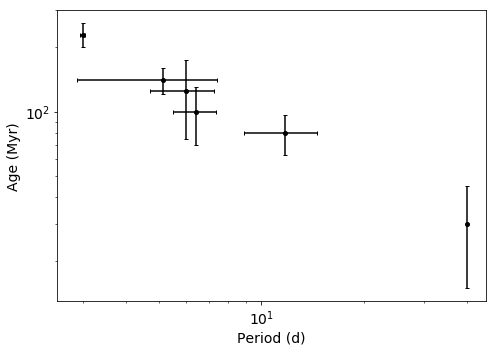

In [51]:
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(111)
ax1.tick_params(axis='both', which='major', labelsize=14)

ax1.errorbar(pd_age_table["ave_pd"], pd_age_table["age"],
             xerr=pd_age_table["e_ave_pd"], yerr=pd_age_table["e_age"],
             capsize=2, linestyle='None',marker='o',color='black', markersize=4)  

ax1.set_xlabel("Period (d)", size=14)
ax1.set_ylabel("Age (Myr)", size=14)

ax1.set_xscale("log")
ax1.set_yscale("log")

fig.tight_layout()
        
plt.show()  
        

## Fitting the points

We expect the PA relation to be of the form: $\log t =  \alpha + \beta \log P$
Where $t$ is the age in years and $P$ is the period in days.

I will use Orthoginal Distance Regression using the scipy ODR package so that I can fit the function while taking into about the uncertainties in both priod and age.

I draw my initial guess from Bono et al. 20015 ([2005ApJ...621..966B](https://ui.adsabs.harvard.edu/abs/2005ApJ...621..966B/abstract)).

In [52]:
# The function we are fitting
def age_func(params, pd):
    a, b = params
    return 10**(a + b*np.log10(pd))*10**-6 # Want our result in Myr

# Create a model for fitting.
age_model = Model(age_func)

# Create a RealData object using our initiated data from above.
data = RealData(pd_age_table["ave_pd"], pd_age_table["age"], 
                sx=pd_age_table["e_ave_pd"], sy=pd_age_table["e_age"])

# Set up ODR with the model and data.
odr = ODR(data, age_model, beta0=[8.2, -0.7])

# Run the regression.
out = odr.run()

# Use the in-built pprint method to give us results.
out.pprint()

Beta: [ 8.73880691 -0.81307792]
Beta Std Error: [0.04322264 0.06028076]
Beta Covariance: [[ 0.01401837 -0.01811418]
 [-0.01811418  0.0272667 ]]
Residual Variance: 0.1332677007027353
Inverse Condition #: 0.022258504311192893
Reason(s) for Halting:
  Sum of squares convergence


#### Best fit P-A relation:

$\log t =  (8.74 \pm 0.04) - (0.81 \pm 0.06) \log P$

#### Plotting the results

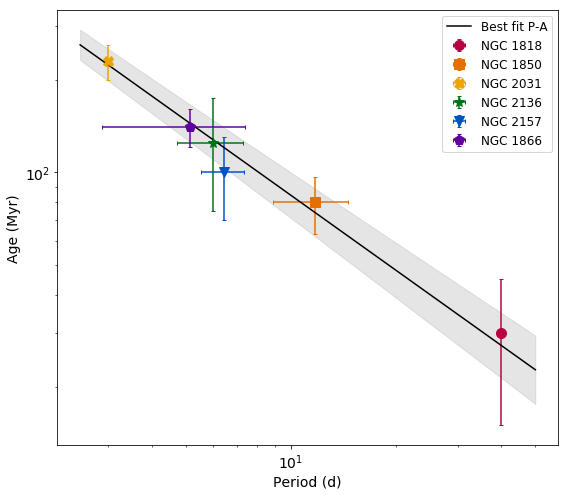

In [76]:
fig = plt.figure(figsize=(8,7))
ax1 = fig.add_subplot(111)
ax1.tick_params(axis='both', which='major', labelsize=14)

colors = ['#b90043','#e57001', '#eca500', '#007215', '#0051c6', '#5f019c']
markers = ['o','s','X','*','v','p']
i = 0
for cluster in pd_age_table:
    ax1.errorbar(cluster["ave_pd"], cluster["age"], xerr=cluster["e_ave_pd"], yerr=cluster["e_age"],
                 capsize=2, linestyle='None', markersize=10, label=cluster["cluster"],
                 color=colors[i], marker=markers[i],) 
    i+=1
    
x_fit = np.linspace(pd_age_table["ave_pd"].min()-0.5, pd_age_table["ave_pd"].max()+10, 1000)
y_fit = age_func(out.beta, x_fit)
ax1.plot(x_fit, y_fit, color='black', label="Best fit P-A")


y_err = np.sqrt(out.sd_beta[0]**2+(out.sd_beta[1]*np.log10(x_fit))**2)
y_min = 10**(np.log10(y_fit)+y_err)
y_max = 10**(np.log10(y_fit)-y_err)
plt.fill_between(x_fit, y_min, y_max, color='gray', alpha=0.2)

ax1.set_xlabel("Period (d)", size=14)
ax1.set_ylabel("Age (Myr)", size=14)

ax1.set_xscale("log")
ax1.set_yscale("log")

ax1.legend(fontsize=12)

fig.tight_layout()

plt.savefig("../doc/plots/period_age_relation.pdf")
        
plt.show()  
        